# 497 Minimum Delta V For Lunar Orbit

In [405]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
import jax.numpy as jnp # this is a thin wrapper to NumPy within JAX
from jax import grad, hessian
from scipy.optimize import minimize
from scipy.optimize import Bounds

## Define Function

In [406]:
# Constants
am = 1834.4 #km
em = 0
rm = 384399 #km
mu = 3.986*10**5 # km^3/s^2

def f(x):
    # Inputs x = [a1, e1, theta_1, theta_d]
    a1 = x[0]
    e1 = x[1]
    theta_1 = jnp.deg2rad(x[2]) # Convert to rad for math
    theta_d = jnp.deg2rad(x[3])

    r1 = (a1*(1-e1**2))/(1+e1*jnp.cos(theta_1)) 
    r2 = (rm**2 + am**2 - 2*rm*am*jnp.cos(theta_d))**(0.5)

    at = (r1+r2) / (2)

    fp1 = jnp.arctan2( (e1*jnp.sin(theta_1)) , (1+e1*jnp.cos(theta_1)) ) # Intital flight path angle
    v1 = ((mu/a1) + ((2*mu)/r1))**(0.5)
    vt1 = ((mu/at) + ((2*mu)/r1))**(0.5)

    delta_1 = ((v1**2) + (vt1**2) - (2*v1*vt1*jnp.cos(fp1)))**(0.5)

    v2 = (mu/r2)**(0.5)
    vt2 = ((mu/at) + ((2*mu)/r2))**(0.5)
    delta_2 = jnp.abs(vt2-v2)

    delta_total =  delta_1 + delta_2

    return delta_total

def f_penalized(x, muk):
    a1 = x[0]
    e1 = x[1]
    theta_1 = jnp.deg2rad(x[2]) # Convert to rad for math
    theta_d = jnp.deg2rad(x[3])

    r1 = (a1*(1-e1**2))/(1+e1*jnp.cos(theta_1)) 
    r2 = (rm**2 + am**2 - 2*rm*am*jnp.cos(theta_d))**(0.5)

    at = (r1+r2) / (2)

    fp1 = jnp.arctan2( (e1*jnp.sin(theta_1)) , (1+e1*jnp.cos(theta_1)) ) # Intital flight path angle
    v1 = ((mu/a1) + ((2*mu)/r1))**(0.5)
    vt1 = ((mu/at) + ((2*mu)/r1))**(0.5)

    delta_1 = ((v1**2) + (vt1**2) - (2*v1*vt1*jnp.cos(fp1)))**(0.5)

    v2 = (mu/r2)**(0.5)
    vt2 = ((mu/at) + ((2*mu)/r2))**(0.5)
    delta_2 = jnp.abs(vt2-v2)

    delta_total =  delta_1 + delta_2
    penalized_f = delta_total + 0.5*muk*(max(0, -c1(x))**2 + max(0, -c2(x))**2 + max(0, -c3(x))**2)
    
    return penalized_f


### Define Constraints and Bounds

In [407]:
# Constraint of Time of Flight of Transfer Orbit
def c1(x):
    # Inputs x = [a1, e1, theta_1, theta_d]
    a1 = x[0]
    e1 = x[1]
    theta_1 = jnp.deg2rad(x[2]) # Convert to rad for math
    theta_d = jnp.deg2rad(x[3])
    r1 = (a1*(1-e1**2))/(1+e1*jnp.cos(theta_1)) 
    r2 = (rm**2 + am**2 - 2*rm*am*jnp.cos(theta_d))**(0.5)
    at = (r1+r2) / (2)
    TOF = (jnp.pi)*(((at**3)/mu)**(0.5))
    TOF = TOF/(24*60*60)
    return 5 - TOF  

# Constraint to make sure periapsis of earth orbit isn't inside the earth/minimum altitude
def c2(x):
    # Inputs x = [a1, e1, theta_1, theta_d]
    a1 = x[0]
    e1 = x[1]
    min_altitude = 400  # km
    rp = (a1 * (1 - e1))
    return rp - (6378 + min_altitude) 

# delta_2 constraint 
def c3(x):
    max_capture_dv = 2 # km/s
    # Inputs x = [a1, e1, theta_1, theta_d]
    a1 = x[0]
    e1 = x[1]
    theta_1 = jnp.deg2rad(x[2]) # Convert to rad for math
    theta_d = jnp.deg2rad(x[3])

    r1 = (a1*(1-e1**2))/(1+e1*jnp.cos(theta_1)) 
    r2 = (rm**2 + am**2 - 2*rm*am*jnp.cos(theta_d))**(0.5)

    at = (r1+r2) / (2)
    
    v2 = (mu/r2)**(0.5)
    vt2 = ((mu/at) + ((2*mu)/r2))**(0.5)
    
    delta_2 = jnp.abs(vt2-v2)

    return max_capture_dv - delta_2 

# Bounds
# Inputs x = [a1, e1, theta_1, theta_d]
# 6800 < a1 < 42000 km
# 0.01 < e1 < 0.99
# 0 < theta_1 < 360deg 
# 0 < theta_2 < 360deg 
bounds = Bounds([6900.0, 0.0,0,0], [42000.0, 0.99,360,360])

In [408]:
ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con3 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

### SLSQP Method

In [409]:
def callbackSLSQP(x):
    xx.append(x) # iterate xk
    fx.append(f(x)) # function value
    c1x.append(ineq_con1['fun'](x)) # constraint evaluation for c1 
    c2x.append(ineq_con2['fun'](x)) # constraint evaluation for c2 
    c3x.append(ineq_con3['fun'](x)) # constraint evaluation for c3

    constraint_violation = np.array([max(0, -c1(x))**2, max(0, -c2(x))**2, max(0, -c3(x))**2])
    mcvk = np.linalg.norm(constraint_violation, np.inf)
    mcv.append(mcvk)

    #print(f'xk {x}, fk {f(x)}, c1 {c1(x)} , c2 {c2(x)}, c3 {c3(x)} ')
    
x0 = np.array([35000,0.6,250.0,250.0])
print(f(x0))

xx = [] 
fx = []
mcv = []
c1x = [] 
c2x = [] 
c3x = [] 
xx.append(x0)
c1x.append(c1(x0))
c2x.append(c2(x0))
c3x.append(c3(x0))
fx.append(f(x0))

res = minimize(f, x0, method='SLSQP',  jac=grad(f),
               constraints=[ineq_con1, ineq_con2, ineq_con3], 
               options={'ftol': 1e-9, 'disp': True},
               bounds=bounds, callback=callbackSLSQP)

xHist1 = xx
fHist1 = fx
c1Hist1 = c1x
c2Hist1 = c2x
c3Hist1 = c3x
mcvHist1 = mcv

print(f'xk {res.x}, fk {f(res.x)}, c1 {c1(res.x)} , c2 {c2(res.x)}, c3 {c3(res.x)} ')
constraint_violation = np.array([max(0, -c1(x))**2, max(0, -c2(x))**2, max(0, -c3(x))**2])
print(np.linalg.norm(constraint_violation, np.inf))

4.6445694
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4293596744537354
            Iterations: 11
            Function evaluations: 25
            Gradient evaluations: 11
xk [3.49999661e+04 8.06342670e-01 3.59992365e+02 2.86111858e+02], fk 1.4293596744537354, c1 0.02788829803466797 , c2 -1.9099388737231493e-11, c3 0.9898848533630371 
0.0


### Trust-Constr Method

In [410]:
def callbackTR(x,res):
    xx.append(x) # iterate xk
    fx.append(f(x)) # function value
    c1x.append(ineq_con1['fun'](x)) # constraint evaluation for c1 
    c2x.append(ineq_con2['fun'](x)) # constraint evaluation for c2 
    c3x.append(ineq_con3['fun'](x)) # constraint evaluation for c3

    constraint_violation = np.array([max(0, -c1(x))**2, max(0, -c2(x))**2, max(0, -c3(x))**2])
    mcvk = np.linalg.norm(constraint_violation, np.inf)
    mcv.append(mcvk)

    #print(f'xk {x}, fk {f(x)}, c1 {c1(x)} , c2 {c2(x)}, c3 {c3(x)} ')
    
x0 = np.array([35000,0.6,250.0,250.0])
print(f(x0))

xx = [] 
fx = []
c1x = [] 
c2x = [] 
c3x = [] 
xx.append(x0)
c1x.append(c1(x0))
c2x.append(c2(x0))
c3x.append(c3(x0))
fx.append(f(x0))

res = minimize(f, x0, method='trust-constr',  jac=grad(f), hess=hessian(f),
               constraints=[ineq_con1, ineq_con2, ineq_con3], 
               options={ 'maxiter' :1000,'disp': True},
               bounds=bounds, callback=callbackTR)

xHist2 = xx
fHist2 = fx
c1Hist2 = c1x
c2Hist2 = c2x
c3Hist2 = c3x
mcvHist2 = mcv


print(f'xk {res.x}, fk {f(res.x)}, c1 {c1(res.x)} , c2 {c2(res.x)}, c3 {c3(res.x)} ')

constraint_violation = np.array([max(0, -c1(x))**2, max(0, -c2(x))**2, max(0, -c3(x))**2])
print(np.linalg.norm(constraint_violation, np.inf))


4.6445694


c:\Users\ZachK\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\ZachK\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\ZachK\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by de

`xtol` termination condition is satisfied.
Number of iterations: 639, function evaluations: 788, CG iterations: 998, optimality: 1.15e-05, constraint violation: 0.00e+00, execution time: 3.8e+01 s.
xk [3.92360889e+04 8.27250240e-01 3.59985258e+02 2.38778019e+02], fk 1.3735673427581787, c1 6.67572021484375e-06 , c2 0.02494889113950194, c3 0.9917662143707275 
0.0


### Quadratic Penalty with Nelder Mead Method

In [411]:
def callbackNM(x):
    xx.append(x) # iterate xk
    fx.append(f(x)) # function value
    c1x.append(ineq_con1['fun'](x)) # constraint evaluation for c1 
    c2x.append(ineq_con2['fun'](x)) # constraint evaluation for c2 
    c3x.append(ineq_con3['fun'](x)) # constraint evaluation for c3

    constraint_violation = np.array([max(0, -c1(x))**2, max(0, -c2(x))**2, max(0, -c3(x))**2])
    mcvk = np.linalg.norm(constraint_violation, np.inf)
    mcv.append(mcvk)

    #print(f'xk {x}, fk {f(x)}, c1 {c1(x)} , c2 {c2(x)}, c3 {c3(x)} ')
    
x0 = np.array([35000,0.6,250.0,250.0])
print(f(x0))

xx = [] 
fx = []
c1x = [] 
c2x = [] 
c3x = []
xx.append(x0)
c1x.append(c1(x0))
c2x.append(c2(x0))
c3x.append(c3(x0))
fx.append(f(x0))

# Quadratic Penalty
mu0 = 1.0
eta = 0.5
rho = 2.0
tau0= 1.0
tauk = tau0
muk  = mu0

while tauk > 1e-4 or muk < 100:
    res = minimize(lambda x: f_penalized(x, muk), x0, method='Nelder-Mead', bounds=bounds, callback=callbackNM,
                   options={'disp': True, 'maxiter': 1000})
    print(f'xk {res.x}, fk {f(res.x)}, c1 {c1(res.x)} , c2 {c2(res.x)}, c3 {c3(res.x)} ')
    x0 = res.x
    muk = muk * rho
    tauk= tauk * eta

xHist3 = xx
fHist3 = fx
c1Hist3 = c1x
c2Hist3 = c2x
c3Hist3 = c3x
mcvHist3 = mcv

print(f'xk {res.x}, fk {f(res.x)}, c1 {c1(res.x)} , c2 {c2(res.x)}, c3 {c3(res.x)} ')

constraint_violation = np.array([max(0, -c1(x))**2, max(0, -c2(x))**2, max(0, -c3(x))**2])
print(np.linalg.norm(constraint_violation, np.inf))

4.6445694
Optimization terminated successfully.
         Current function value: 1.343205
         Iterations: 154
         Function evaluations: 320
xk [4.20000000e+04 8.38593433e-01 3.59959311e+02 1.80188127e+02], fk 1.3430628776550293, c1 -0.016860008239746094 , c2 1.0758030668448555, c3 0.9928973913192749 
Optimization terminated successfully.
         Current function value: 1.343347
         Iterations: 91
         Function evaluations: 229
xk [4.20000000e+04 8.38593433e-01 3.59959311e+02 1.80188127e+02], fk 1.3430628776550293, c1 -0.016860008239746094 , c2 1.0758030668448555, c3 0.9928973913192749 
Optimization terminated successfully.
         Current function value: 1.343631
         Iterations: 84
         Function evaluations: 213
xk [4.19998371e+04 8.38607233e-01 3.59959227e+02 1.84160775e+02], fk 1.3430695533752441, c1 -0.016756534576416016 , c2 0.469899499247731, c3 0.9928905963897705 
Optimization terminated successfully.
         Current function value: 1.343785
       

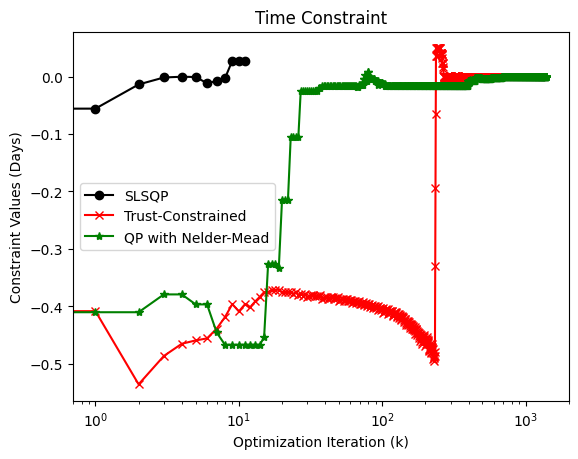

In [412]:
# Maximum Constraint Violation vs Iterations Plot
plt.plot(c1Hist1, marker='o', c='k', label='SLSQP')
plt.plot(c1Hist2, marker='x', c='r', label='Trust-Constrained')
plt.plot(c1Hist3, marker='*', c='g', label='QP with Nelder-Mead')
plt.xscale('log')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Values (Days)')
plt.title('Time Constraint')
plt.legend()

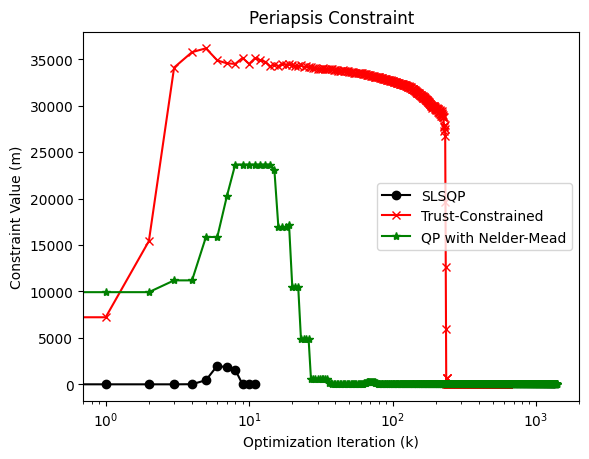

In [413]:
# Maximum Constraint Violation vs Iterations Plot
plt.plot(c2Hist1, marker='o', c='k', label='SLSQP')
plt.plot(c2Hist2, marker='x', c='r', label='Trust-Constrained')
plt.plot(c2Hist3, marker='*', c='g', label='QP with Nelder-Mead')
plt.xscale('log')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value (m)')
plt.title('Periapsis Constraint')
plt.legend()

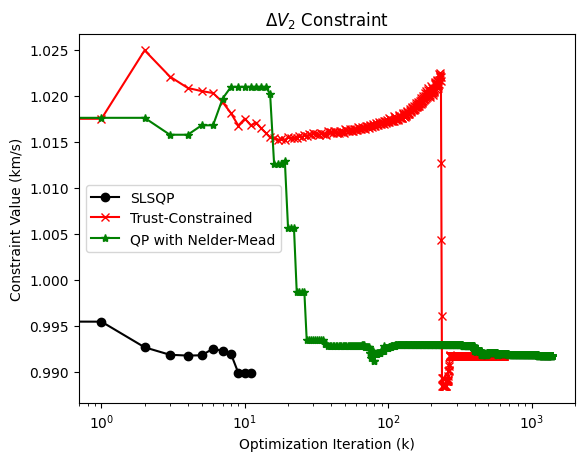

In [414]:
# Maximum Constraint Violation vs Iterations Plot
plt.plot(c3Hist1, marker='o', c='k', label='SLSQP')
plt.plot(c3Hist2, marker='x', c='r', label='Trust-Constrained')
plt.plot(c3Hist3, marker='*', c='g', label='QP with Nelder-Mead')
plt.xscale('log')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value (km/s)')
plt.title(r'$\Delta V_2$ Constraint')
plt.legend()

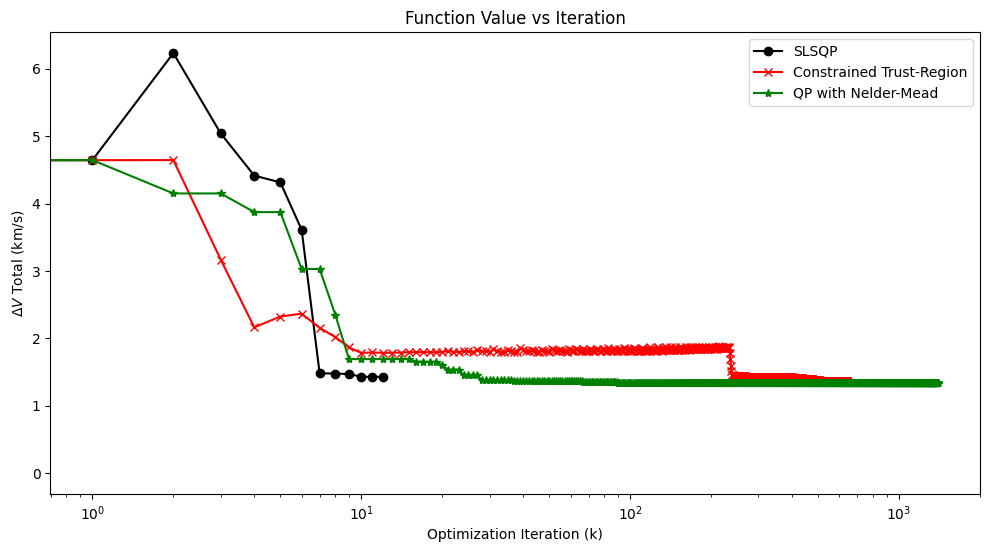

In [415]:
# fk vs Iterations Plot
fHist1.insert(0,0)
fHist2.insert(0,0)
fHist3.insert(0,0)

plt.figure(figsize=(12, 6))
plt.plot(fHist1, marker='o', c='k', label='SLSQP')
plt.plot(fHist2, marker='x', c='r', label='Constrained Trust-Region')
plt.plot(fHist3, marker='*', c='g', label='QP with Nelder-Mead')
plt.xscale('log')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel(r'$\Delta V$ Total (km/s)')
plt.title('Function Value vs Iteration')
plt.legend()

### Transfer Trajectory Plots

In [416]:
def plot_transfer(x):
        
    # Unpack Vars
    a1 = x[0]
    e1 = x[1]
    theta_1 = jnp.deg2rad(x[2]) # Convert to rad for math
    theta_d = jnp.deg2rad(x[3])

    # Earth Orbit
    theta = np.linspace(0,2*np.pi,1000)
    r_earth_orbit = (a1 * (1 - e1**2)) / (1 + e1 * np.cos(theta))
    x_earth_orbit = r_earth_orbit * np.cos(theta)
    y_earth_orbit = r_earth_orbit * np.sin(theta)
    
    # Moon Orbit
    r1 = (a1*(1 - e1**2)) / (1 + e1 * np.cos(theta_1))
    r2 = (rm**2 + am**2 - 2*rm*am*jnp.cos(theta_d))**(0.5)
    at = (r1+r2+am) / (2)
    TOF = (jnp.pi)*(((at**3)/mu)**(0.5))
    moon_angle =  np.rad2deg((((mu)/(at**3))**(0.5))*(TOF))
    x_moon = r2*jnp.cos(jnp.deg2rad(moon_angle))
    y_moon = r2*jnp.sin(jnp.deg2rad(moon_angle))
    theta_moon = np.linspace(0,2*np.pi,10000)
    x_moon_orbit_final = x_moon + am * np.cos(theta_moon)
    y_moon_orbit_final = y_moon + am * np.sin(theta_moon)
    
    # Depature Point
    x1 = r1 * np.cos(theta_1)
    y1 = r1 * np.sin(theta_1)
    
    # Transfer Elipse 
    et = (r2-r1)/(r2+r1)
    theta_transfer = np.linspace(np.deg2rad(0), np.deg2rad(180.0), 500)  # from departure angle to arrival angle
    r_transfer =+(at * (1 - et**2)) / (1 + et * np.cos(theta_transfer))
    x_transfer = r_transfer * jnp.cos(theta_transfer)
    y_transfer = r_transfer * jnp.sin(theta_transfer)
    
    # PLOT
    #plt.plot(x_earth_orbit, y_earth_orbit, alpha=0.5)
    #plt.plot(x_moon_orbit_final, y_moon_orbit_final, alpha=0.5)
    plt.plot(x_transfer, y_transfer, alpha=0.3, color='g')

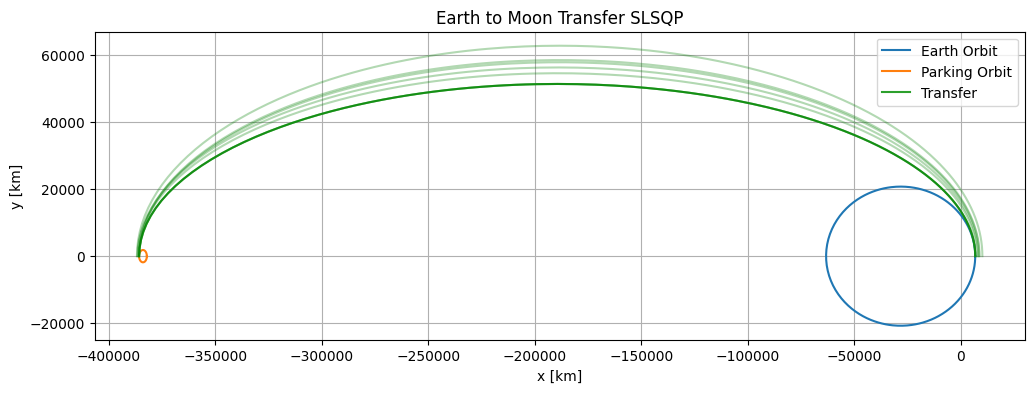

In [417]:
method = xHist1

# Plot Stuff
plt.figure(figsize=(12,4))
indexes = np.arange(0, len(method), round(len(method)/5))
np.append(indexes,len(method))
indexes = indexes[1:]

# Unpack Vars
x = method[-1]
a1 = x[0]
e1 = x[1]
theta_1 = jnp.deg2rad(x[2]) # Convert to rad for math
theta_d = jnp.deg2rad(x[3])

# Earth Orbit
theta = np.linspace(0,2*np.pi,500)
r_earth_orbit = (a1 * (1 - e1**2)) / (1 + e1 * np.cos(theta))
x_earth_orbit = r_earth_orbit * np.cos(theta)
y_earth_orbit = r_earth_orbit * np.sin(theta)

# Moon Orbit
r1 = (a1*(1 - e1**2)) / (1 + e1 * np.cos(theta_1))
r2 = (rm**2 + am**2 - 2*rm*am*jnp.cos(theta_d))**(0.5)
at = (r1+r2+am) / (2)
TOF = (jnp.pi)*(((at**3)/mu)**(0.5))
moon_angle =  np.rad2deg((((mu)/(at**3))**(0.5))*(TOF))
x_moon = r2*jnp.cos(jnp.deg2rad(moon_angle))
y_moon = r2*jnp.sin(jnp.deg2rad(moon_angle))
theta_moon = np.linspace(0,2*np.pi,10000)
x_moon_orbit_final = x_moon + am * np.cos(theta_moon)
y_moon_orbit_final = y_moon + am * np.sin(theta_moon)

# Depature Point
x1 = r1 * np.cos(theta_1)
y1 = r1 * np.sin(theta_1)

# Transfer Elipse 
et = (r2-r1)/(r2+r1)
theta_transfer = np.linspace(np.deg2rad(0), np.deg2rad(180.0), 500)  # from departure angle to arrival angle
r_transfer =+(at * (1 - et**2)) / (1 + et * np.cos(theta_transfer))
x_transfer = r_transfer * jnp.cos(theta_transfer)
y_transfer = r_transfer * jnp.sin(theta_transfer)

# PLOT
plt.plot(x_earth_orbit, y_earth_orbit, label="Earth Orbit", alpha=1)
plt.plot(x_moon_orbit_final, y_moon_orbit_final, label="Parking Orbit", alpha=1)
plt.plot(x_transfer, y_transfer, label="Transfer", alpha=1)


#plot_transfer(method[0])
plot_transfer(method[1])
plot_transfer(method[2])
plot_transfer(method[3])
#plot_transfer(method[4])
#plot_transfer(method[5])
plot_transfer(method[6])
plot_transfer(method[7])
#plot_transfer(method[8])
#plot_transfer(method[9])
plot_transfer(method[10])
plot_transfer(method[11])


#for i in indexes:
#    plot_transfer(method[i])
#    print(method[i])

plt.title('Earth to Moon Transfer SLSQP')
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.legend()
plt.grid(True)
plt.savefig('SLSPQ.png')  # Saves as a PNG file


# Departure and arrival points
#plt.scatter(x1, y1, color='green', label="Departure Point")
#plt.scatter(x_moon, y_mooncolor='green', label="Departure Point")